In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline
os.listdir("test_images/")

['test2.jpg',
 'test1.jpg',
 'test6.jpg',
 'test5.jpg',
 'straight_lines2.jpg',
 'test3.jpg',
 'straight_lines1.jpg',
 'test4.jpg']

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


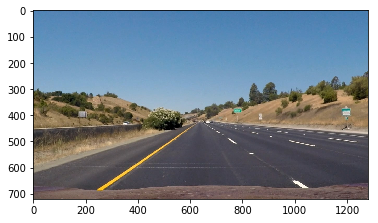

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
def calibrate_camera(img_dir):
    
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for filename in os.listdir(img_dir):
        img = mpimg.imread(os.path.join("camera_cal/" , filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            # Draw and display the corners
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

def threshold(img, s_thresh=(170, 255), sx_thresh=(10, 200)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #direction threshold
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely,abs_sobelx)
    direction = np.absolute(direction)
    direction_binary = np.zeros_like(direction)
    direction_binary[(direction >= np.pi/6) & (direction <= np.pi/2)] = 1
   
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    #Combined threshold                                           
    combined_condition = ((sxbinary == 1) & (direction_binary == 1))
                                               
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    s_condition = (s_channel>s_thresh[0]) & (s_channel<s_thresh[1])
                                               
    final_binary = np.zeros_like(combined_condition)
    final_binary[(s_condition | combined_condition)] = 1
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1 
    
    return np.uint8(final_binary)

def warp(undistorted_img):
    
    height = undistorted_img.shape[0]
    width = undistorted_img.shape[1]

    src1 = [width // 2 - 76, height * 0.625]
    src2 = [width // 2 + 76, height * 0.625]
    src3 = [-100, height]
    src4 = [width + 100, height]
    src = np.float32([src1, src2, src3, src4])
    
    dst1 = [100, 0]
    dst2 = [width - 100, 0]
    dst3 = [100, height]
    dst4 = [width - 100, height]
    dst = np.float32([dst1, dst2, dst3, dst4])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(undistorted_img, M, (width, height))
    return (warped)

def unwarp(warped_img):
    
    height = warped_img.shape[0]
    width = warped_img.shape[1]

    src1 = [width // 2 - 76, height * 0.625]
    src2 = [width // 2 + 76, height * 0.625]
    src3 = [-100, height]
    src4 = [width + 100, height]
    src = np.float32([src1, src2, src3, src4])
    
    dst1 = [100, 0]
    dst2 = [width - 100, 0]
    dst3 = [100, height]
    dst4 = [width - 100, height]
    dst = np.float32([dst1, dst2, dst3, dst4])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    unwarped = cv2.warpPerspective(warped_img, Minv, (width, height))
    return unwarped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


def search_around_poly(binary_warped, img, left_fit, right_fit):
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_new, right_fit_new = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    lanes = unwarp(window_img)
    
    result = cv2.addWeighted(img, 1, lanes, 0.3, 0)
    
    return result, left_fit_new, right_fit_new, left_fitx, right_fitx

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit


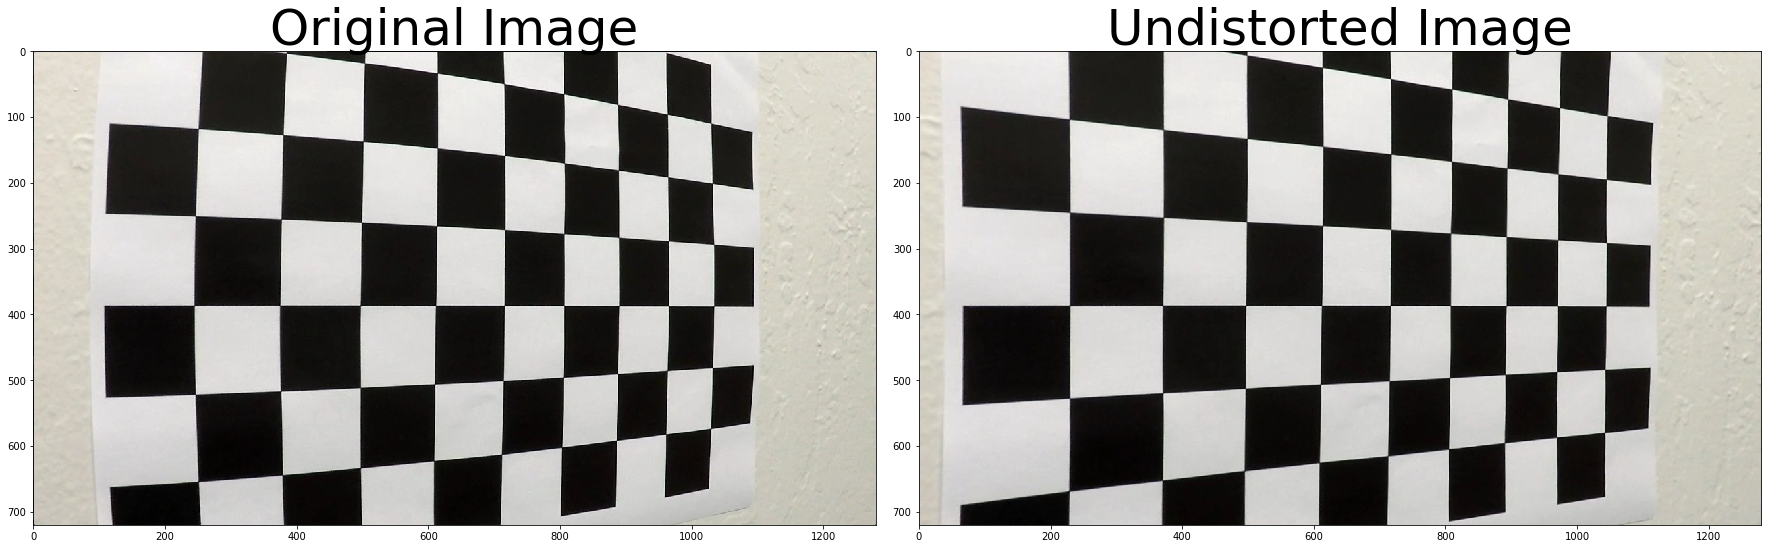

In [4]:
cal1 = mpimg.imread('camera_cal/calibration5.jpg')
mtx, dist = calibrate_camera("camera_cal/")
undistorted = cv2.undistort(cal1, mtx, dist, None, mtx)

path = 'output_images/'
cv2.imwrite(os.path.join(path , 'undistorted.jpg'), undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

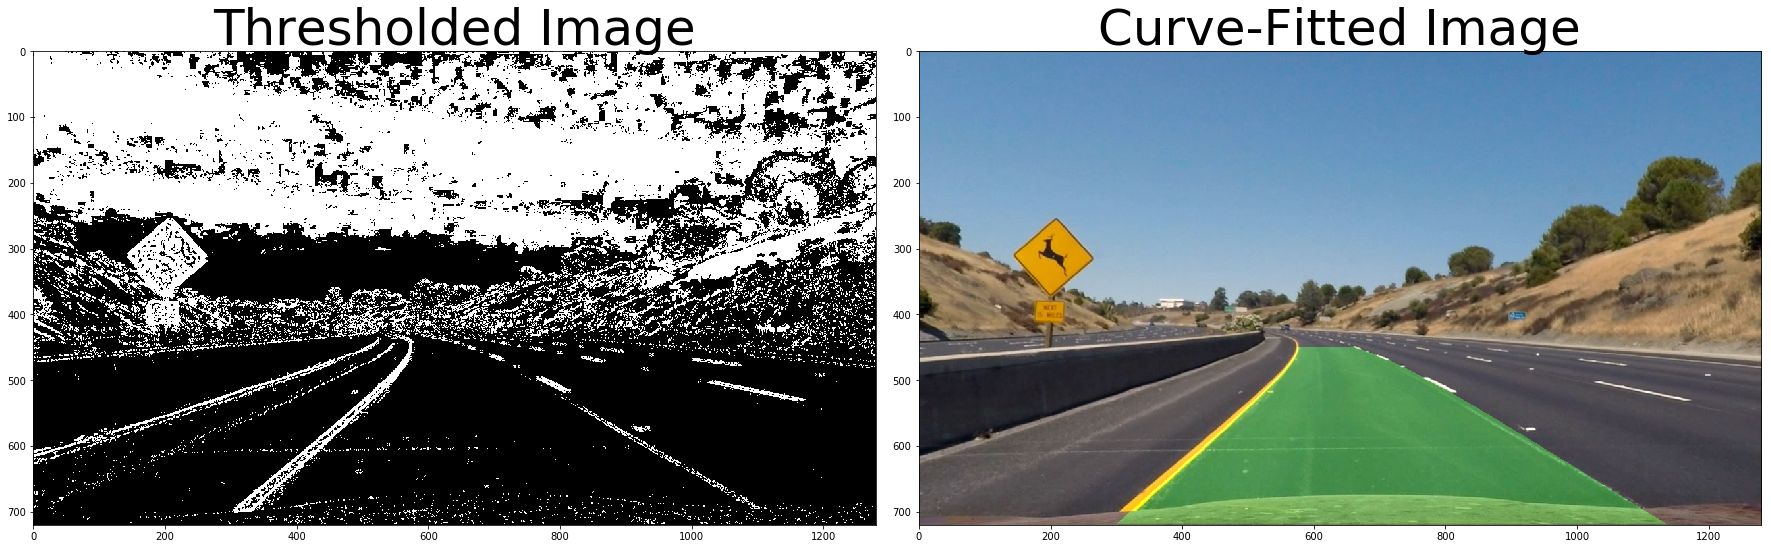

In [9]:
raw = mpimg.imread('test_images/test2.jpg')
img = cv2.undistort(raw, mtx, dist, None, mtx)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th = threshold(img,(100, 255),(10, 200))
warped = warp(th)
left_fit, right_fit = fit_polynomial(warped)
out_img, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(warped, img, left_fit, right_fit)

cv2.imwrite(os.path.join(path , 'thresholded.jpg'), cv2.cvtColor(th*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite(os.path.join(path , 'warped.jpg'), cv2.cvtColor(warped*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite(os.path.join(path , 'fitted.jpg'), cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(th, cmap='gray')
ax1.set_title('Thresholded Image', fontsize=50)
ax2.imshow(out_img, cmap='gray')
ax2.set_title('Curve-Fitted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [6]:
def radius (leftx, rightx, img_shape):
    xm_per_pix=3.7/800
    ym_per_pix = 25/720
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)


def car_offset(leftx, rightx, img_shape):
    
    xm_per_pix=3.7/800
    mid = img_shape[1]//2
    car_pos = (leftx[-1] + rightx[-1])/2    
    offset = (mid - car_pos) * xm_per_pix

    return offset

def display_info(img, leftx, rightx):    

    xm_per_pix=3.7/800
    ym_per_pix = 25/720
    
    curvature_rads = radius(leftx, rightx, img.shape,)
    offsetx = car_offset(leftx, rightx, img.shape)

    final_image = img.copy()
    cv2.putText(final_image, 'Left lane curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3)
    cv2.putText(final_image, 'Right lane curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3)
    cv2.putText(final_image, 'Car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3)
    
    return final_image

In [10]:
off = car_offset(left_fitx, right_fitx, out_img.shape)
print(off)
curvature = radius(left_fitx, right_fitx, out_img.shape)
print(curvature)
fin = display_info(out_img, left_fitx, right_fitx)
cv2.imwrite(os.path.join(path , 'final.jpg'), cv2.cvtColor(fin, cv2.COLOR_BGR2RGB))

-0.262259574082
(323.06196631083014, 224.37425688707347)


True

In [20]:
mtx, dist = calibrate_camera("camera_cal/")
init = None
def process_image(image):
    
    img = cv2.undistort(image, mtx, dist, None, mtx)
    thresholded = threshold(img,(100, 255),(10, 200))
    warped_image = warp(thresholded)
    left_fit, right_fit = fit_polynomial(warped_image)        
    out_img, left_fit_new, right_fit_new, left_fitx, right_fitx = search_around_poly(warped_image, image, left_fit, right_fit)
    left_fit = left_fit_new
    right_fit = right_fit_new
    final_img = display_info(out_img, left_fitx, right_fitx)
        
    return final_img

In [21]:
white_output = 'project2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project2.mp4
[MoviePy] Writing video project2.mp4


100%|█████████▉| 1260/1261 [06:01<00:00,  3.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project2.mp4 

CPU times: user 3min 16s, sys: 40 s, total: 3min 56s
Wall time: 6min 4s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))